# Smart Wine
### Become a wine expert while on a budget

In [394]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly
import pydotplus
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize,word_tokenize 
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pprint
from collections import Counter
%matplotlib inline

In [395]:
df=pd.read_csv(r'wine-reviews/winemag-data-130k.csv',encoding='latin1')

## Part I: International Wine Geography

### Import the data and calculate average prices and ratings

In [380]:
#read in country codes from github (plotly map must use country codes instead of actual country names)
df_ref = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
df_ref.set_index('COUNTRY',inplace=True)

#need to make naming consistent (US vs United States), so create new list from current index, rename US, and then reset
#index with the new list
as_list = df_ref.index.tolist()
idx = as_list.index('United States')
as_list[idx] = 'US'
df_ref.index = as_list

#get the number of wines per country
df1=df.groupby('country').size()

#join github country list and our country list to consolidate data
df1_asDF=pd.DataFrame(df1)
df2=df_ref.join(df1_asDF)

#rename columns for referencing later
df2.columns=['GDP','code','count']

#calculate average rating and prices
df2['Average rating'] = df.groupby('country').mean()['points']
df2['Average price'] = df.groupby('country').mean()['price']

#replace all NA's with 0 so we can graph
df2.fillna(0,inplace=True)

#for the rating, the data we used only had wines that scored 80 points or more, so we set the 0 values to 80 in just
#the rating column so that when we map the results the differences between the country ratings are more clear
df2['rating_adj']=df2['Average rating'].mask(df2['Average rating']==0,80)

### Mapping

In [381]:
#logs in to my plotly account so that we can use the maps
plotly.tools.set_credentials_file(username='angelazhang97', api_key='pt6m0L1mEtkJAvzm3qZ7')

In [382]:

data = [ dict(
        type = 'choropleth',
        locations = df2['code'],
        z = df2['count'],
        text = df2.index,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of Wines'),
      ) ]

layout = dict(
    title = 'Wine Distribution Across the World',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d1-world-map' )

We can see that most of the wines reviewed come from the US, France, Spain, Argentina, Chile, and Australia (the small country above Brazil is French Guinea, which is counted as a territory of France)

In [383]:
#graph the average rating (adjusted), after setting ratings of 0 to 80
data = [ dict(
        type = 'choropleth',
        locations = df2['code'],
        z = df2['rating_adj'],
        text = df2.index,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Average Rating of Wines'),
      ) ]

layout = dict(
    title = 'Average Rating (Adjusted) of Wines Across the World',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d2-world-map' )

All countries appear to score quite high on the ratings end besides Mexico, Peru, Brazil, Egypt, and Ukraine.

In [384]:
#graph the average price of the wine around the world
data = [ dict(
        type = 'choropleth',
        locations = df2['code'],
        z = df2['Average price'],
        text = df2.index,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Average Price of Wines'),
      ) ]

layout = dict(
    title = 'Average Price of Wines Across the World',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~angelazhang97/0 or inside your plot.ly account where it is named 'd3-world-map'


Switzerland has the highest average wine price (85) and the cheapest comes from Ukraine (9)

## Part II: Wine Geography in the USA

This is a choropleth map that visually portrays where in Unite States these wines are coming from. Data set's winery column was used to find the respective address of the winery. Through the address, we were able to locate the state from where the wines were from so that we can count the instances by each state and create a choropleth graph. This gives us a bird's eye view of where most of the wines produced in US are coming from.

In [385]:
#!pip install plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [386]:
#get USA wines
df_usa = df.loc[df['country'] == 'US']

In [387]:
#group wines by state by getting state codes and calculate points, price and counts
df1=df_usa.replace(np.nan,'',regex=True)
df1=df1.loc[df.province!='Washington-Oregon']
df1=df1.loc[df.province!='America']
df_count = df1.groupby(['province']).size().reset_index().rename(index=str, columns={0: "count states"})
df_points = df1.groupby('province')['points'].mean().reset_index().rename(index=str, columns={0: "count states"})
df1.price=(pd.to_numeric(df.price, errors='coerce'))
df_price=df1.groupby('province')['price'].mean().reset_index().rename(index=str, columns={0: "count states"})

In [388]:
df_states = df1.groupby(['province']).size().reset_index().rename(index=str, columns={0: "count states"})
df_states['State Abbrv'] = np.NaN
df_states['State Abbrv'].iloc[0] = 'AZ'
df_states['State Abbrv'].iloc[1] = 'CA'
df_states['State Abbrv'].iloc[2] = 'CO'
df_states['State Abbrv'].iloc[3] = 'CT'
df_states['State Abbrv'].iloc[4] = 'HI'
df_states['State Abbrv'].iloc[5] = 'ID'
df_states['State Abbrv'].iloc[6] = 'IL'
df_states['State Abbrv'].iloc[7] = 'IA'
df_states['State Abbrv'].iloc[8] = 'KY'
df_states['State Abbrv'].iloc[9] = 'MA'
df_states['State Abbrv'].iloc[10] = 'MI'
df_states['State Abbrv'].iloc[11] = 'MO'
df_states['State Abbrv'].iloc[12] = 'NV'
df_states['State Abbrv'].iloc[13] = 'NJ'
df_states['State Abbrv'].iloc[14] = 'NM'
df_states['State Abbrv'].iloc[15] = 'NY'
df_states['State Abbrv'].iloc[16] = 'NC'
df_states['State Abbrv'].iloc[17] = 'OH'
df_states['State Abbrv'].iloc[18] = 'OR'
df_states['State Abbrv'].iloc[19] = 'PA'
df_states['State Abbrv'].iloc[20] = 'RI'
df_states['State Abbrv'].iloc[21] = 'TX'
df_states['State Abbrv'].iloc[22] = 'VT'
df_states['State Abbrv'].iloc[23] = 'VA'
df_states['State Abbrv'].iloc[24] = 'WA'
df_states = df_states[['province','State Abbrv']]

/Users/Daues/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Mapping

In [389]:
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='yn2334', api_key='s98cKjt9OWHWBmOMEuXE')

df_count = df_count.set_index('province').join(df_states.set_index('province'))

for col in df_count.columns:
    df_count[col] = df_count[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False, 
        locations = df_count['State Abbrv'],
        z = df_count['count states'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of wines")
        ) ]

layout = dict(
        title = 'Number of Wines per Region',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~yn2334/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [390]:
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='yn2334', api_key='s98cKjt9OWHWBmOMEuXE')

df_points = df_points.set_index('province').join(df_states.set_index('province'))

for col in df_points.columns:
    df_points[col] = df_points[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_points['State Abbrv'],
        z = df_points['points'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Ratings of Wines")
        ) ]

layout = dict(
        title = 'Ratings of Wines per Region',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~yn2334/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [391]:
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='yn2334', api_key='s98cKjt9OWHWBmOMEuXE')

df_price = df_price.set_index('province').join(df_states.set_index('province'))

for col in df_price.columns:
    df_price[col] = df_price[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False, 
        locations = df_price['State Abbrv'],
        z = df_price['price'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Prices of Wines")
        ) ]

layout = dict(
        title = 'Prices of Wines by Region',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~yn2334/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


## Part III: Text Mining of Wine Descriptions

#### First, find out important words to know when studying wines

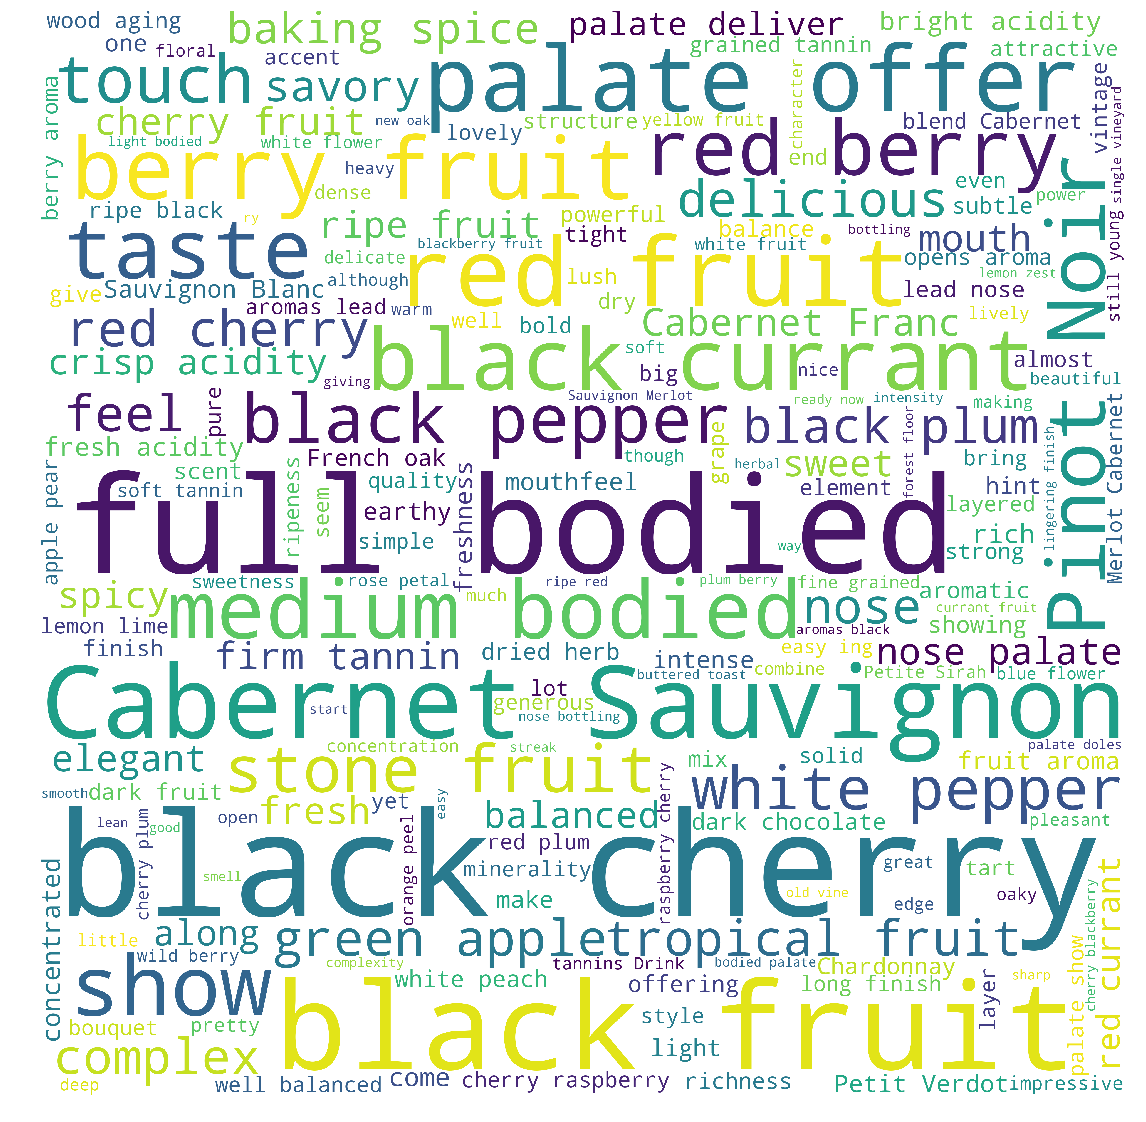

In [399]:
text = ''
for d in df['description']:
    text += ' ' + d

DELETE_WORDS = ['drink','deliver','feel','followed',
                'give','ing','make','offers',
                'seem','show','wine',
                'Drink','Drink now'
               ]
        
DELETE_WORDS = ['wine','note','flavor','drink', 'Drink now']
def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

#Remove short words
MIN_LENGTH = 0
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string

text_string = remove_words(text)
text_string = remove_short_words(text_string)
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=5000,height=5000,).generate(text_string)

plt.figure( figsize=(20,20) )
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [400]:
#create a list of tuples for all the descriptions for each of the top 10 largest province
df_grouped = df.groupby('province').size().nlargest(10)
provinces = df_grouped.index
output_by_province = list()

for p in provinces:
    new_df = df[df['province'] == p]
    text = '' 
    for d in new_df['description']:
        text += ' ' + d       
    output_by_province.append((p,text))

#### Create WordClouds for each of the top 10 most-appeared province

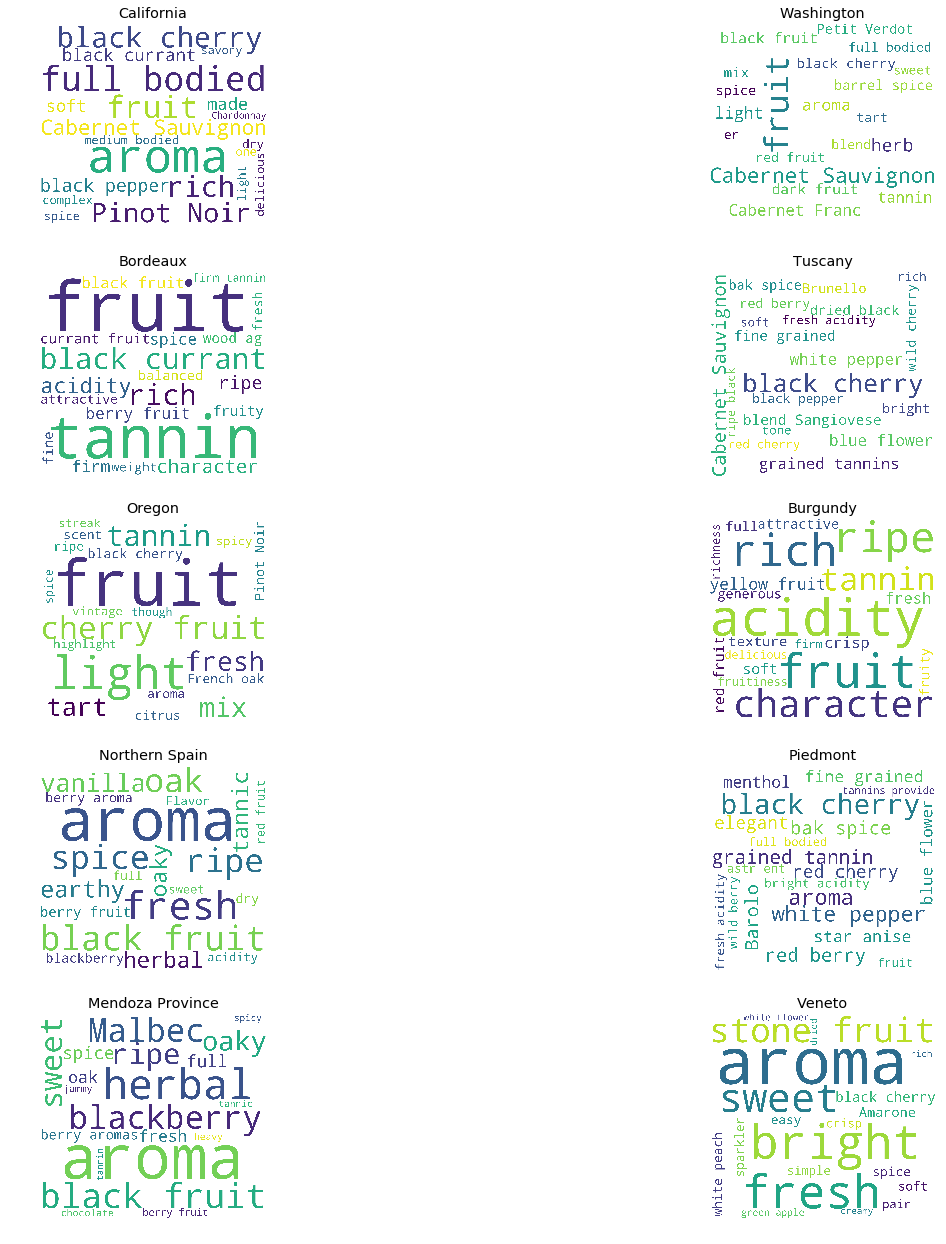

In [401]:
#Remove unwanted words
DELETE_WORDS = ['along','bit','bottling','bring','come','close','drink','deliver','feel','finish','flavor',
                'followed','give','good','hint','ing','make','mouth','nose','note','now','offers','palate',
                'open','ready','seem','show','smell','structure','taste','wine','well',
                'Barrel sample','Drink','Drink now'
                ]

def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

MIN_LENGTH = 0
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string

COL_NUM = 2
ROW_NUM = 5
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(22,22))

for i in range(0,len(output_by_province)):
    text_string = remove_words(output_by_province[i][1])
    text_string = remove_short_words(text_string)
    ax = axes[i//2, i%2] 
    ax.set_title(output_by_province[i][0])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=2200,height=2000,max_words=20).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

#### Create WordClouds for each of the top 10 most-appeared grape variety

In [402]:
#With 10 most-appeared grape varieties
df_grouped = df.groupby('variety').size().nlargest(10)
most_variety = df_grouped.index
output_by_variety = list()

for v in most_variety:
    new_df = df[df['variety'] == v]
    text = ''    
    for d in new_df['description']:
        text += ' ' + d        
    output_by_variety.append((v,text))

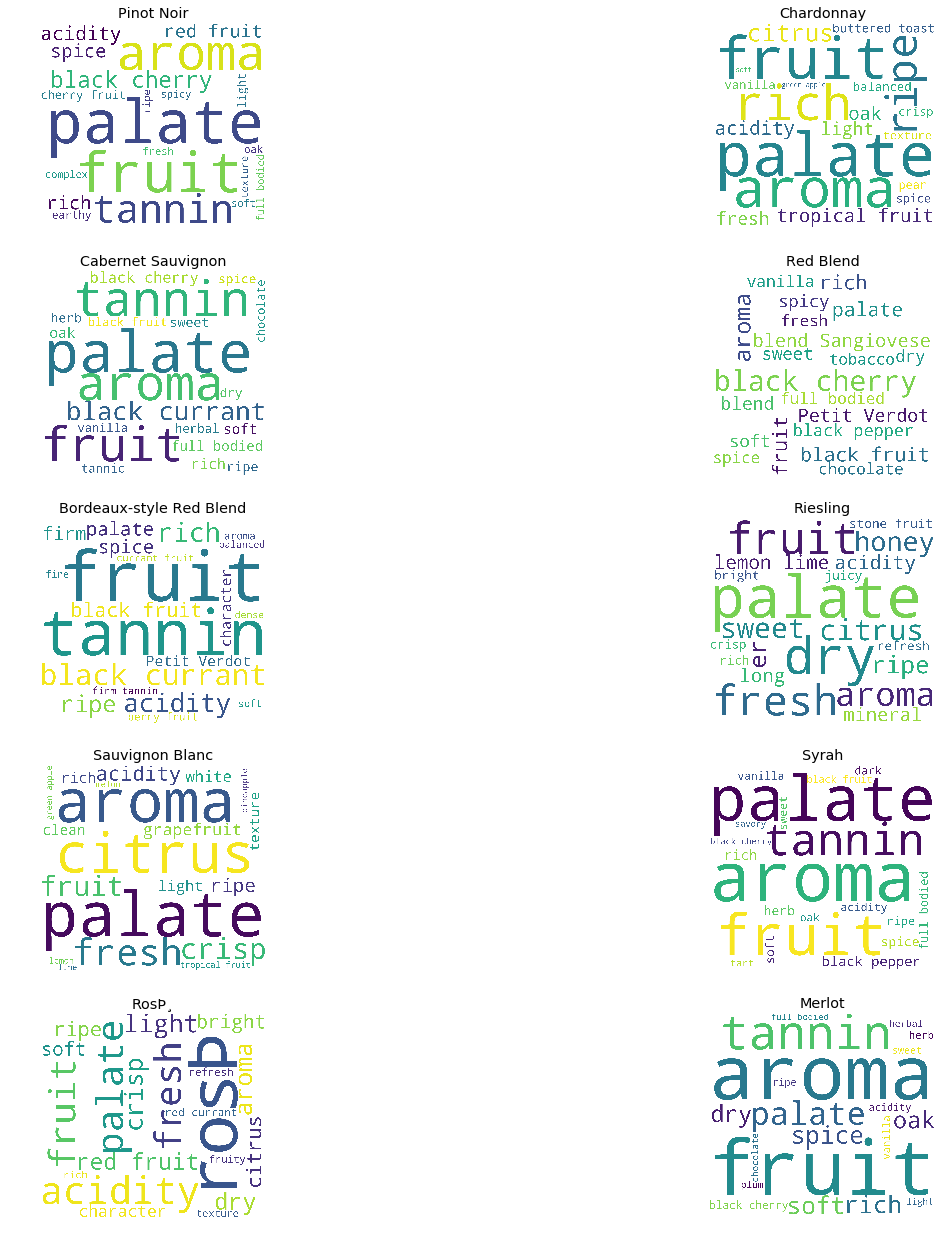

In [403]:
DELETE_WORDS = ['along','bit','bottling','bring','come','close','drink','deliver','feel','finish','flavor',
                'followed','give','good','hint','ing','make','mouth','nose','note','now','offers','palate'
                'seem','show','structure','taste','vineyard','wine','well',
                'Barrel sample','Drink','Drink now',
                'Zin','Chardonnay','Cabernet','Sauvignon','Pinot','Noir','fandel','Blanc','Cab',
                'Riesling','Riesl','dry Riesl','Syrah','rosé ','Merlot'
                ]

def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

#Remove short words
MIN_LENGTH = 0
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string


#Set up side by side clouds
COL_NUM = 2
ROW_NUM = 5
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(22,22))

for i in range(0,len(output_by_variety)):
    text_string = remove_words(output_by_variety[i][1])
    text_string = remove_short_words(text_string)
    ax = axes[i//2, i%2] 
    ax.set_title(output_by_variety[i][0])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=2200,height=2000,max_words=20).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

#### Adjectives describing wines and their frequencies

In [404]:
# Function to convert a raw text to a string of words
# The input is a single string (a raw text), and the output is a single string (a preprocessed text)
def text_to_words(raw_text):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) 
    words = letters_only.lower().split()
    stops = set(stopwords.wo rds("english"))                  
    meaningful_words = [w for w in words if not w in stops]  
    return( " ".join( meaningful_words ))  

SyntaxError: invalid syntax (<ipython-input-404-a78ce0e3aaf5>, line 6)

### By provinces

In [ ]:
Insignif_Words = ['aromas','big', 'wine','finish','good','great','nose','new','touch'
                 ]

final_wine_adj = list()
for i in range(0,len(output_by_province)):
    raw_text = output_by_province[i][1]
    processed_texts = [text_to_words(raw_text)]
    wine_adj = list()
    word_list = nltk.word_tokenize(processed_texts[0])
    pos_tag=nltk.pos_tag(word_list)
    for j in pos_tag:
        if j[1] == 'JJ' and j[0] not in Insignif_Words:
            wine_adj.append(j[0])
    final_wine_adj.append((output_by_province[i][0],wine_adj))

In [ ]:
COL_NUM = 2
ROW_NUM = 5
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i in range(0,len(final_wine_adj)):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    frequency = Counter(final_wine_adj[i][1])
    topwords = frequency.most_common(10)
    topwords_df = pd.DataFrame(topwords, columns = ['Features', 'Frequency'])
    topwords_df.set_index('Features',inplace=True)
    ax.set_title(final_wine_adj[i][0])
    topwords_df.plot(kind='barh', ax=ax)
plt.tight_layout()

### By Grape Variety

In [ ]:
Insignif_Words = ['aromas','big', 'wine','finish','good','great','nose','new','touch'
                 ]

final_wine_adj = list()
for i in range(0,len(output_by_variety)):
    raw_text = output_by_variety[i][1]
    processed_texts = [text_to_words(raw_text)]
    wine_adj = list()
    word_list = nltk.word_tokenize(processed_texts[0])
    pos_tag=nltk.pos_tag(word_list)
    for j in pos_tag:
        if j[1] == 'JJ' and j[0] not in Insignif_Words:
            wine_adj.append(j[0])
    final_wine_adj.append((output_by_variety[i][0],wine_adj))

In [ ]:
COL_NUM = 2
ROW_NUM = 5
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i in range(0,len(final_wine_adj)):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    frequency = Counter(final_wine_adj[i][1])
    topwords = frequency.most_common(10)
    topwords_df = pd.DataFrame(topwords, columns = ['Features', 'Frequency'])
    topwords_df.set_index('Features',inplace=True)
    ax.set_title(final_wine_adj[i][0])
    topwords_df.plot(kind='barh', ax=ax)
plt.tight_layout()

## Part IV: Understanding Wine Prices

## Data Cleansing

In [70]:
def year_extract(title):
    for j in title:
        if j.startswith('20') or j.startswith('19'):
            if len(j)==4:
                return int(j)
            else:
                return None
            
def cheapness(price):
    if price <= 30:
        return 0
    elif 30<price<=80:
        return 1
    elif 80<price<=150:
        return 2
    else:
        return 3

def get_price_range(cheapness):
    if cheapness<=0.5:
        return [0,30]
    if 0.5<cheapness<=1:
        return [30,80]
    if 1<cheapness<=2:
        return [80,150]
    if cheapness>=3:
        return [150,]

In [71]:
#Extract year from title
df['title_split']=df.title.apply(lambda x: x.split())
df['year']=df.title_split.apply(lambda y: year_extract(y))
df['age']=2018-df['year']

In [72]:
#Remove nonexistent prices
df = df[pd.notnull(df['price'])]
name=df.columns[0]
df.rename(columns={name:'ID'},inplace=True)
df.set_index('ID',inplace=True)

In [73]:
#Create cheapness category
df['cheapness']=df.price.apply(lambda x: cheapness(x))

## Create Dummy Variables

In [74]:
df_reg = df[['designation','province','variety','points','age','cheapness']]
df_dummy=pd.DataFrame(index=df_reg.index)

In [75]:
#Create dummy variables for province and variety
for elem in df_reg.groupby('province').size().nlargest(100).index:
    string='province_'+str(elem)
    df_dummy[string]=df_reg['province']==elem
for elem in df_reg.groupby('variety').size().nlargest(200).index:
    string='variety_'+str(elem)
    df_dummy[string]=df_reg['variety']==elem

In [76]:
#Add the other variables we need
df_dummy['cheapness']=df_reg.cheapness
df_dummy['age']=df_reg.age
df_dummy['points']=df_reg.points

In [77]:
#Remove rows we cannot use
df_dummy.dropna(inplace=True)
df_dummy=df_dummy.loc[df_dummy[df_dummy.columns[0:len(df_dummy.columns)-3]].sum(axis=1)>=2]

In [78]:
df_dummy.head()

,province_California,province_Washington,province_Oregon,province_Tuscany,province_Bordeaux,province_Northern Spain,province_Mendoza Province,province_Burgundy,province_Piedmont,province_New York,...,variety_Gros Manseng,variety_Marsanne-Roussanne,variety_Merlot-Cabernet Franc,variety_Picolit,variety_Verdejo-Viura,variety_Cabernet Sauvignon-Cabernet Franc,variety_Monastrell-Syrah,cheapness,age,points
ID,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,7.0,87
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,5.0,87
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,5.0,87
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,1,6.0,87
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,5.0,87


## Decision Tree Approach 
### Can we categorize wine into certain price ranges

In [79]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_dummy, test_size = 0.3)

In [80]:
#Create train and test data
params=list(train.columns)
params.remove('cheapness')
x_train = train[params]
y_train = train[['cheapness']]
x_test = test[params]
y_test = test[['cheapness']]

In [127]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
model = tree.DecisionTreeRegressor(max_depth=15)
model.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [128]:
print("Training R-Square",model.score(x_train,y_train))
print("Testing R-Square",model.score(x_test,y_test))

Training R-Square 0.5279620755893448
Testing R-Square 0.45031457405432085


### Visualize the Tree if possible

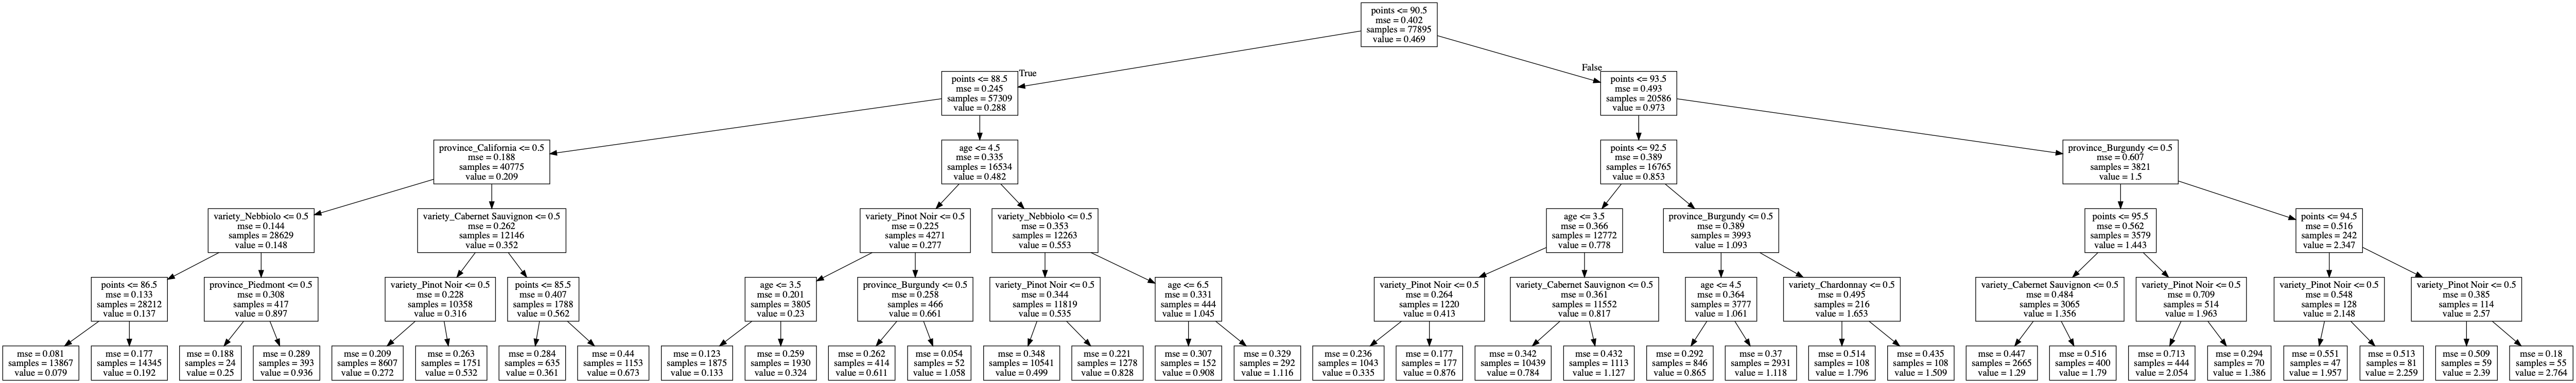

In [111]:
feature_names = [key for key in x_train if not key=='cheapness']
from IPython.display import Image
dot_data = tree.export_graphviz(model, out_file=None,feature_names=feature_names)
graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Show Case: Understanding Wine Prices

In [84]:
def get_price_predict(province,variety,age,points):
    a=np.ndarray(shape=(0),dtype=np.float32)
    v1='province_'+province
    v2='variety_'+variety
    for i in x_train.columns[0:len(x_train.columns)-2]:
        if i==v1:
            a=np.append(a,1)
        elif i==v2:
            a=np.append(a,1)
        else:
            a=np.append(a,0)
    a=np.append(a,float(age))
    a=np.append(a,int(points))
    return a

In [431]:
#Get a price range for a province, variety, age and points. Do not enter old wines - won´t work
province='California'
variety='Chardonnay'
age=5
points=90
array = get_price_predict(province,variety,age,points)
df_test=pd.DataFrame(array.reshape(1,-1),columns=x_test.columns)
cheapness=model.predict(df_test)
print('For a {} from {} expect a price range of {}:'.format(variety,province,get_price_range(cheapness[0])))
#print('Tree value:',cheapness)

province2='Burgundy'
variety2='Chardonnay'
age2=5
points2=90
array = get_price_predict(province2,variety2,age2,points2)
df_test=pd.DataFrame(array.reshape(1,-1),columns=x_test.columns)
cheapness=model.predict(df_test)
print('For a {} from {} expect a price range of {}:'.format(variety2,province2,get_price_range(cheapness[0])))

#print('Tree value:',cheapness)

For a Chardonnay from California expect a price range of [0, 30]:
For a Chardonnay from Burgundy expect a price range of [30, 80]:


### Visualize the Price Distribution for this wine

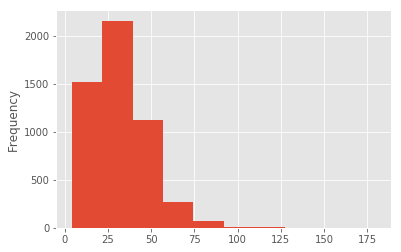

In [422]:
df.loc[(df['province']==province)&(df['variety']==variety)&(df['price']<250)].price.plot(kind='hist')

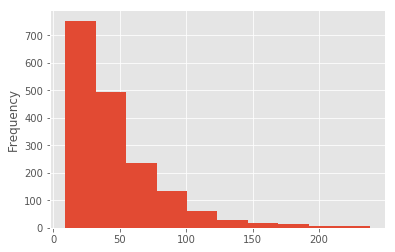

In [423]:
df.loc[(df['province']==province2)&(df['variety']==variety2)&(df['price']<250)].price.plot(kind='hist')

In [99]:
#Use this for reference for frequent wine regions and varieties
df.groupby(['province','variety']).size().nlargest(20)

province          variety                 
California        Pinot Noir                  6875
                  Cabernet Sauvignon          5668
                  Chardonnay                  5157
Bordeaux          Bordeaux-style Red Blend    3078
Oregon            Pinot Noir                  2779
California        Zinfandel                   2633
Piedmont          Nebbiolo                    2199
Tuscany           Red Blend                   1984
California        Syrah                       1862
Tuscany           Sangiovese                  1841
California        Sauvignon Blanc             1801
Burgundy          Chardonnay                  1793
California        Red Blend                   1791
                  Merlot                      1390
Mendoza Province  Malbec                      1356
Washington        Cabernet Sauvignon          1356
Burgundy          Pinot Noir                  1207
Northern Spain    Tempranillo                 1195
Washington        Syrah                

## K-Means Cluster Analysis
### Can we find clusteres in the variety, province, age and points of wines to predict the price?

In [234]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [301]:
df_kmeans = df[['designation','province','variety','points','age','price']]
df_dummy2=pd.DataFrame(index=df_kmeans.index)

for elem in df_kmeans.groupby('province').size().nlargest(100).index:
    string='province_'+str(elem)
    df_dummy2[string]=df_kmeans['province']==elem
for elem in df_kmeans.groupby('variety').size().nlargest(200).index:
    string='variety_'+str(elem)
    df_dummy2[string]=df_kmeans['variety']==elem
    
df_dummy2['age']=df_kmeans.age
df_dummy2['price']=df_kmeans.price
df_dummy2['points']=df_kmeans.points
df_dummy2.dropna(inplace=True)

In [303]:
df_dummy2=df_dummy2.astype(int)

In [304]:
clmns=list(df_dummy2.columns)
train2, test2 = train_test_split(df_dummy2, test_size = 0.3)

params=list(train2.columns)
params.remove('price')
x_train2 = train2[params]
y_train2 = train2[['price']]
x_test2 = test2[params]
y_test2 = test2[['price']]

In [305]:
kmeans = KMeans(n_clusters=100, random_state=0)
kmeans_fit=kmeans.fit(x_train2)
labels = kmeans_fit.labels_
train2['clusters'] = labels


/Users/Daues/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [306]:
clmns.extend(['clusters'])

In [307]:
kmeans_predict=kmeans.predict(x_test2)
test2['clusters']=kmeans_predict

/Users/Daues/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [308]:
#Train Result
prices_df=pd.DataFrame(train2.groupby('clusters')['price'].mean().reset_index())
result_train = pd.merge(train2, prices_df, how='left', on=['clusters', 'clusters'])
rms = np.sqrt(mean_squared_error(result_train.price_x, result_train.price_y))
r2=r2_score(result_train.price_x, result_train.price_y)
print(rms)
print(r2)

33.11101588535182
0.2846161945981954


In [309]:
#Test Result
prices_df=pd.DataFrame(train2.groupby('clusters')['price'].mean().reset_index())
result = pd.merge(test2, prices_df, how='left', on=['clusters', 'clusters'])
rms = np.sqrt(mean_squared_error(result.price_x, result.price_y))
r2=r2_score(result.price_x, result.price_y)
print(rms)
print(r2)

40.17218363918251
0.22588373879436707


## Sentiment Analysis: Wine Reviews

In [342]:
df_merged=pd.read_csv(r'saved.csv',encoding='latin1')
df_merged=df_merged.set_index(df_merged.columns[0])

/Users/Daues/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [343]:
df_merged.dropna(inplace=True)


In [344]:
df_merged=df_merged[['price','pos_sent','neg_sent','points']]

In [345]:
df_merged.price=pd.to_numeric(df_merged.price)
df_merged.points=pd.to_numeric(df_merged.points)
df_merged.pos_sent=pd.to_numeric(df_merged.pos_sent)
df_merged.neg_sent=pd.to_numeric(df_merged.neg_sent)

### Understanding the relationship between sentiment and price

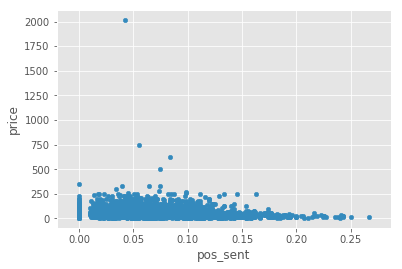

In [346]:
df_merged[['pos_sent','price']].plot.scatter('pos_sent','price')

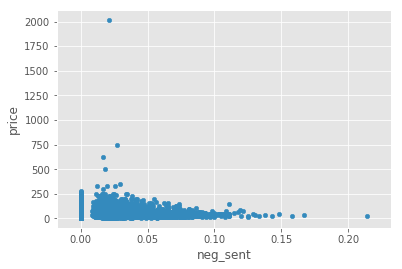

In [347]:
df_merged[['neg_sent','price']].plot.scatter('neg_sent','price')

### Understanding the relationship between sentiment and points

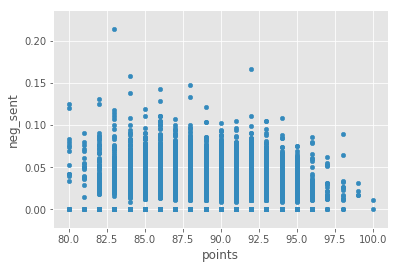

In [349]:
df_merged[['points','neg_sent']].plot.scatter('points','neg_sent')

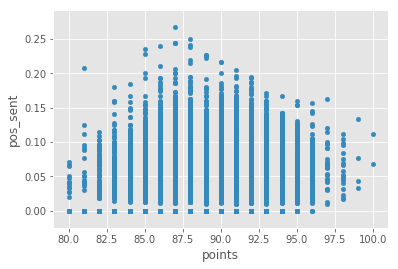

In [350]:
df_merged[['points','pos_sent']].plot.scatter('points','pos_sent')

In [409]:
df_merged.points.corr(df_merged.pos_sent)


0.10120775660063036

In [408]:
df_merged.points.corr(df_merged.neg_sent)

-0.017472630123928353